# *Bank Marketing campaign*

## *1.Business problem & Data understanding*
 

### *Business problem understanding*
Berikut ini adalah kumpulan data Bank yang sedang menjalankan kampanye pemasaran untuk menawarkan deposito berjangka kepada pelanggan, kampanye yang dilakukan sebagian besar dilakukan pada panggilan telepon langsung menawarkan klien bank untuk menempatkan deposito berjangka jika telah semua upaya penandaan klien telah setuju untuk menempatkan deposit - variabel target ditandai 'ya', dan jika tidak'tidak'

Target:
- Tidak(0): Tidak menempatkan deposit

- ya(1): Menempatkan deposit

### *Problem statement*
Bank sedang menghadapi tantangan dalam mengoptimalkan kampanye pemasaran untuk menawarkan deposito berjangka melalui panggilan telepon langsung. Kampanye ini seringkali menghasilkan tingkat konversi yang rendah, menghabiskan sumber daya yang signifikan untuk menargetkan pelanggan yang tidak tertarik. Oleh karena itu, diperlukan solusi analitik untuk memprediksi apakah seseorang pelanggan akan menempatkan deposito ( yes) atau (tidak) berdasarkan atribut mereka

### *Goals*

Maka berdasarkan permasalahan tersebut, bank ingin meningkatkan efektivitas kampanye pemasaran dengan cara memprioritaskan pelanggan yang lebih potensial untuk dihubungi, sehingga meningkatkan tingkat konversi pelanggan yang setuju membuka deposito berjangka ( deposit: yes).

### *Analytic Approach:*

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan kandidat yang mau menempatkan deposito atau tidak 

Kemudian kita akan membangun model klasifikasi yang akan membantu bank untuk dapat memprediksi probabilitas seorang kandidat yang ingin menempatkan deposito atau tidak

### *Metric Evaluation*

Type 1 error: False Positive
Konsekuensi: Sia-sianya biaya kampanye, waktu dan sumber daya

Type 2 error: False negative
Konsekuensi: Kehilangan calon depositor

Berdasarkan konsekuensinya, Maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost kampanye dari bank tersebut, tetapi tanpa membuat menjadi kurangnya/tidak cukup kandidat depositor yang dibutuhkan bank, Jadi harus kita seimbangkan nanti antara precision dan recallnya dari kelas positive(kandidat depositor)

In [261]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting
from sklearn.model_selection import train_test_split

# Library preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Library untuk missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Library untuk scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# Cross Validation 
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metric Evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [262]:
df = pd.read_csv('data_bank_marketing_campaign.csv')
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [264]:
df['deposit'].value_counts()

deposit
no     4081
yes    3732
Name: count, dtype: int64

## *Data Cleaning*

In [265]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

In [266]:
df.duplicated().sum()

8

In [267]:
df.drop_duplicates(inplace=True)

Seperti yang terlihat Data tidak memiliki Nan di semua kolom dan hanya 8 duplikat, Data duplikat akan dihapus karena hanya sedikit dan mungkin bisa membuat analisis tidak akurat. Dan Data siap untuk dianalisis

## *Analysis*

In [268]:
df['age'].nunique()

75

<Axes: >

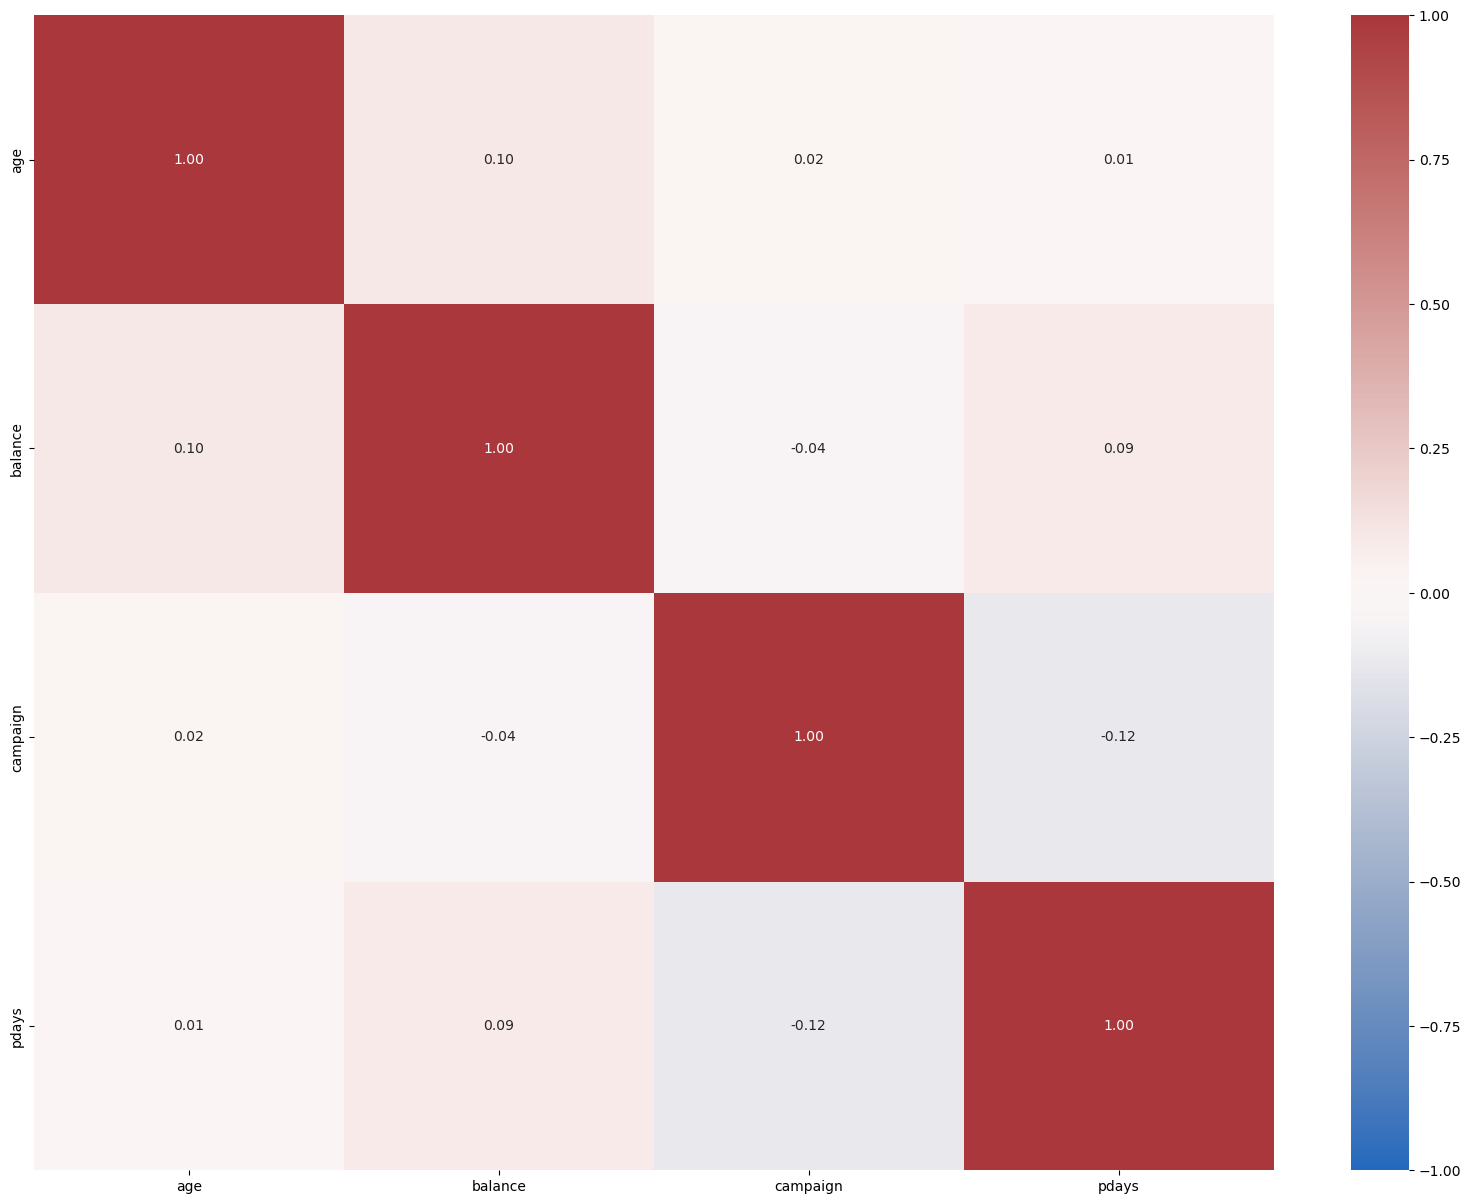

In [269]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr('spearman', numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag', fmt='.2f')

Sebagian besar variabel menunjukkan hubungan lemah satu sama lain (korelasi mendekati 0).
    - Variabel yang kurang berkorelasi (tidak multikolinear) berarti setiap variabel memberikan informasi unik. Ini memungkinkan model prediksi atau analitik untuk bekerja lebih baik dengan memanfaatkan setiap variabel secara independen.
    - Usia (age) tidak berhubungan signifikan dengan saldo pelanggan (balance) atau jumlah kampanye yang diikuti (campaign). Oleh karena itu, segmentasi pelanggan berdasarkan usia mungkin kurang relevan jika tujuan Anda adalah menargetkan pelanggan berdasarkan kampanye pemasaran.

- Korelasi negatif lemah (-0.12) antara jumlah kampanye (campaign) dan jumlah hari sejak kontak terakhir (pdays) menunjukkan sedikit tren bahwa pelanggan yang baru saja dihubungi mungkin lebih jarang diikutsertakan dalam kampanye tambahan.
    - Pelanggan yang sering dihubungi mungkin sudah kehilangan ketertarikan terhadap produk atau layanan.
    - Disarankan untuk mengatur frekuensi kontak secara bijaksana agar tidak membuat pelanggan merasa terganggu (menghindari "over-marketing").

- Korelasi antara balance dan pdays. Korelasi lemah positif (0.09) menunjukkan sedikit hubungan antara saldo pelanggan dan waktu sejak kontak terakhir.
    - Pelanggan dengan saldo lebih tinggi mungkin cenderung tetap dalam kontak lebih lama dengan bisnis.
    - Strategi: Bisnis dapat memanfaatkan ini untuk menargetkan pelanggan dengan saldo tinggi melalui penawaran atau promosi eksklusif.

- Korelasi sangat rendah antara usia dan variabel lain seperti saldo (balance) atau jumlah kampanye (campaign).
    - Usia pelanggan mungkin tidak menjadi penentu utama dalam keberhasilan kampanye pemasaran
    - Strategi: Alih-alih berfokus pada usia, perusahaan dapat mempertimbangkan faktor lain seperti riwayat kontak atau status keuangan.

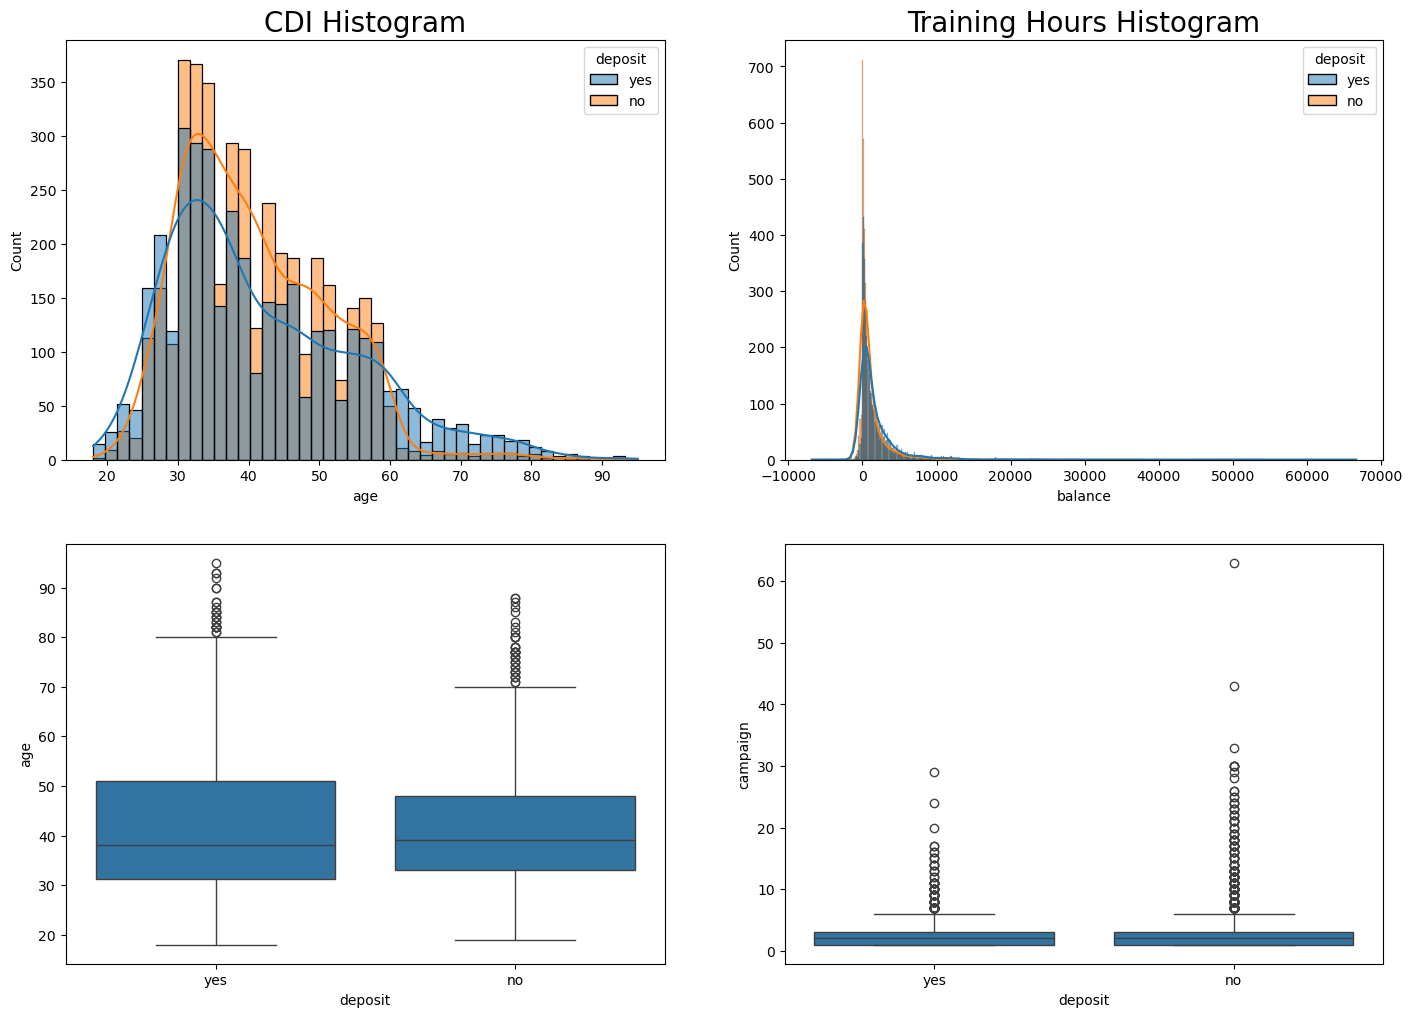

In [270]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=df,x='age',hue='deposit',kde=True)
plt.title('CDI Histogram',fontsize=20)

plt.subplot(222)
sns.histplot(data=df,x='balance',hue='deposit',kde=True)
plt.title('Training Hours Histogram',fontsize=20)

plt.subplot(223)
sns.boxplot(data=df,y='age', x='deposit')

plt.subplot(224)
sns.boxplot(data=df,y='campaign', x='deposit')
plt.show()

Histogram Age:
- Pelanggan yang melakukan deposit (label "yes") cenderung berusia antara 30-50 tahun sedangkan pelanggan yang tidak melakukan deposit (label "no") tersebar lebih merata, dengan puncak usia sekitar 30-40 tahun.
- Kelompok usia 30-50 tahun adalah target yang lebih prospektif untuk kampanye deposito, karena mereka menunjukkan kecenderungan lebih tinggi untuk membuka deposito.

Histogram Balance:
- Sebagian besar pelanggan memiliki saldo mendekati 0, baik untuk "yes" maupun "no". Pelanggan dengan saldo positif lebih tinggi (contohnya, di atas 10.000) cenderung lebih banyak melakukan deposit.
- Pelanggan dengan saldo yang lebih besar dapat dianggap memiliki kapasitas finansial lebih baik untuk berinvestasi.

Boxplot Age:
- Median usia untuk pelanggan yang melakukan deposit dan tidak melakukan deposit relatif mirip (sekitar 40 tahun), tetapi distribusi usia untuk pelanggan yang tidak melakukan deposit memiliki lebih banyak variasi. Ada beberapa outlier pada usia lebih tinggi (80+), tetapi kontribusi mereka kecil.

Boxplot Campaign:
- Pelanggan yang tidak melakukan deposit (label "no") memiliki jumlah kontak yang lebih besar (campaign lebih tinggi) dibandingkan pelanggan yang melakukan deposit (label "yes"). 
- Over-Marketing Warning: Menghubungi pelanggan terlalu sering dapat menurunkan efektivitas kampanye dan bahkan mengganggu pelanggan.

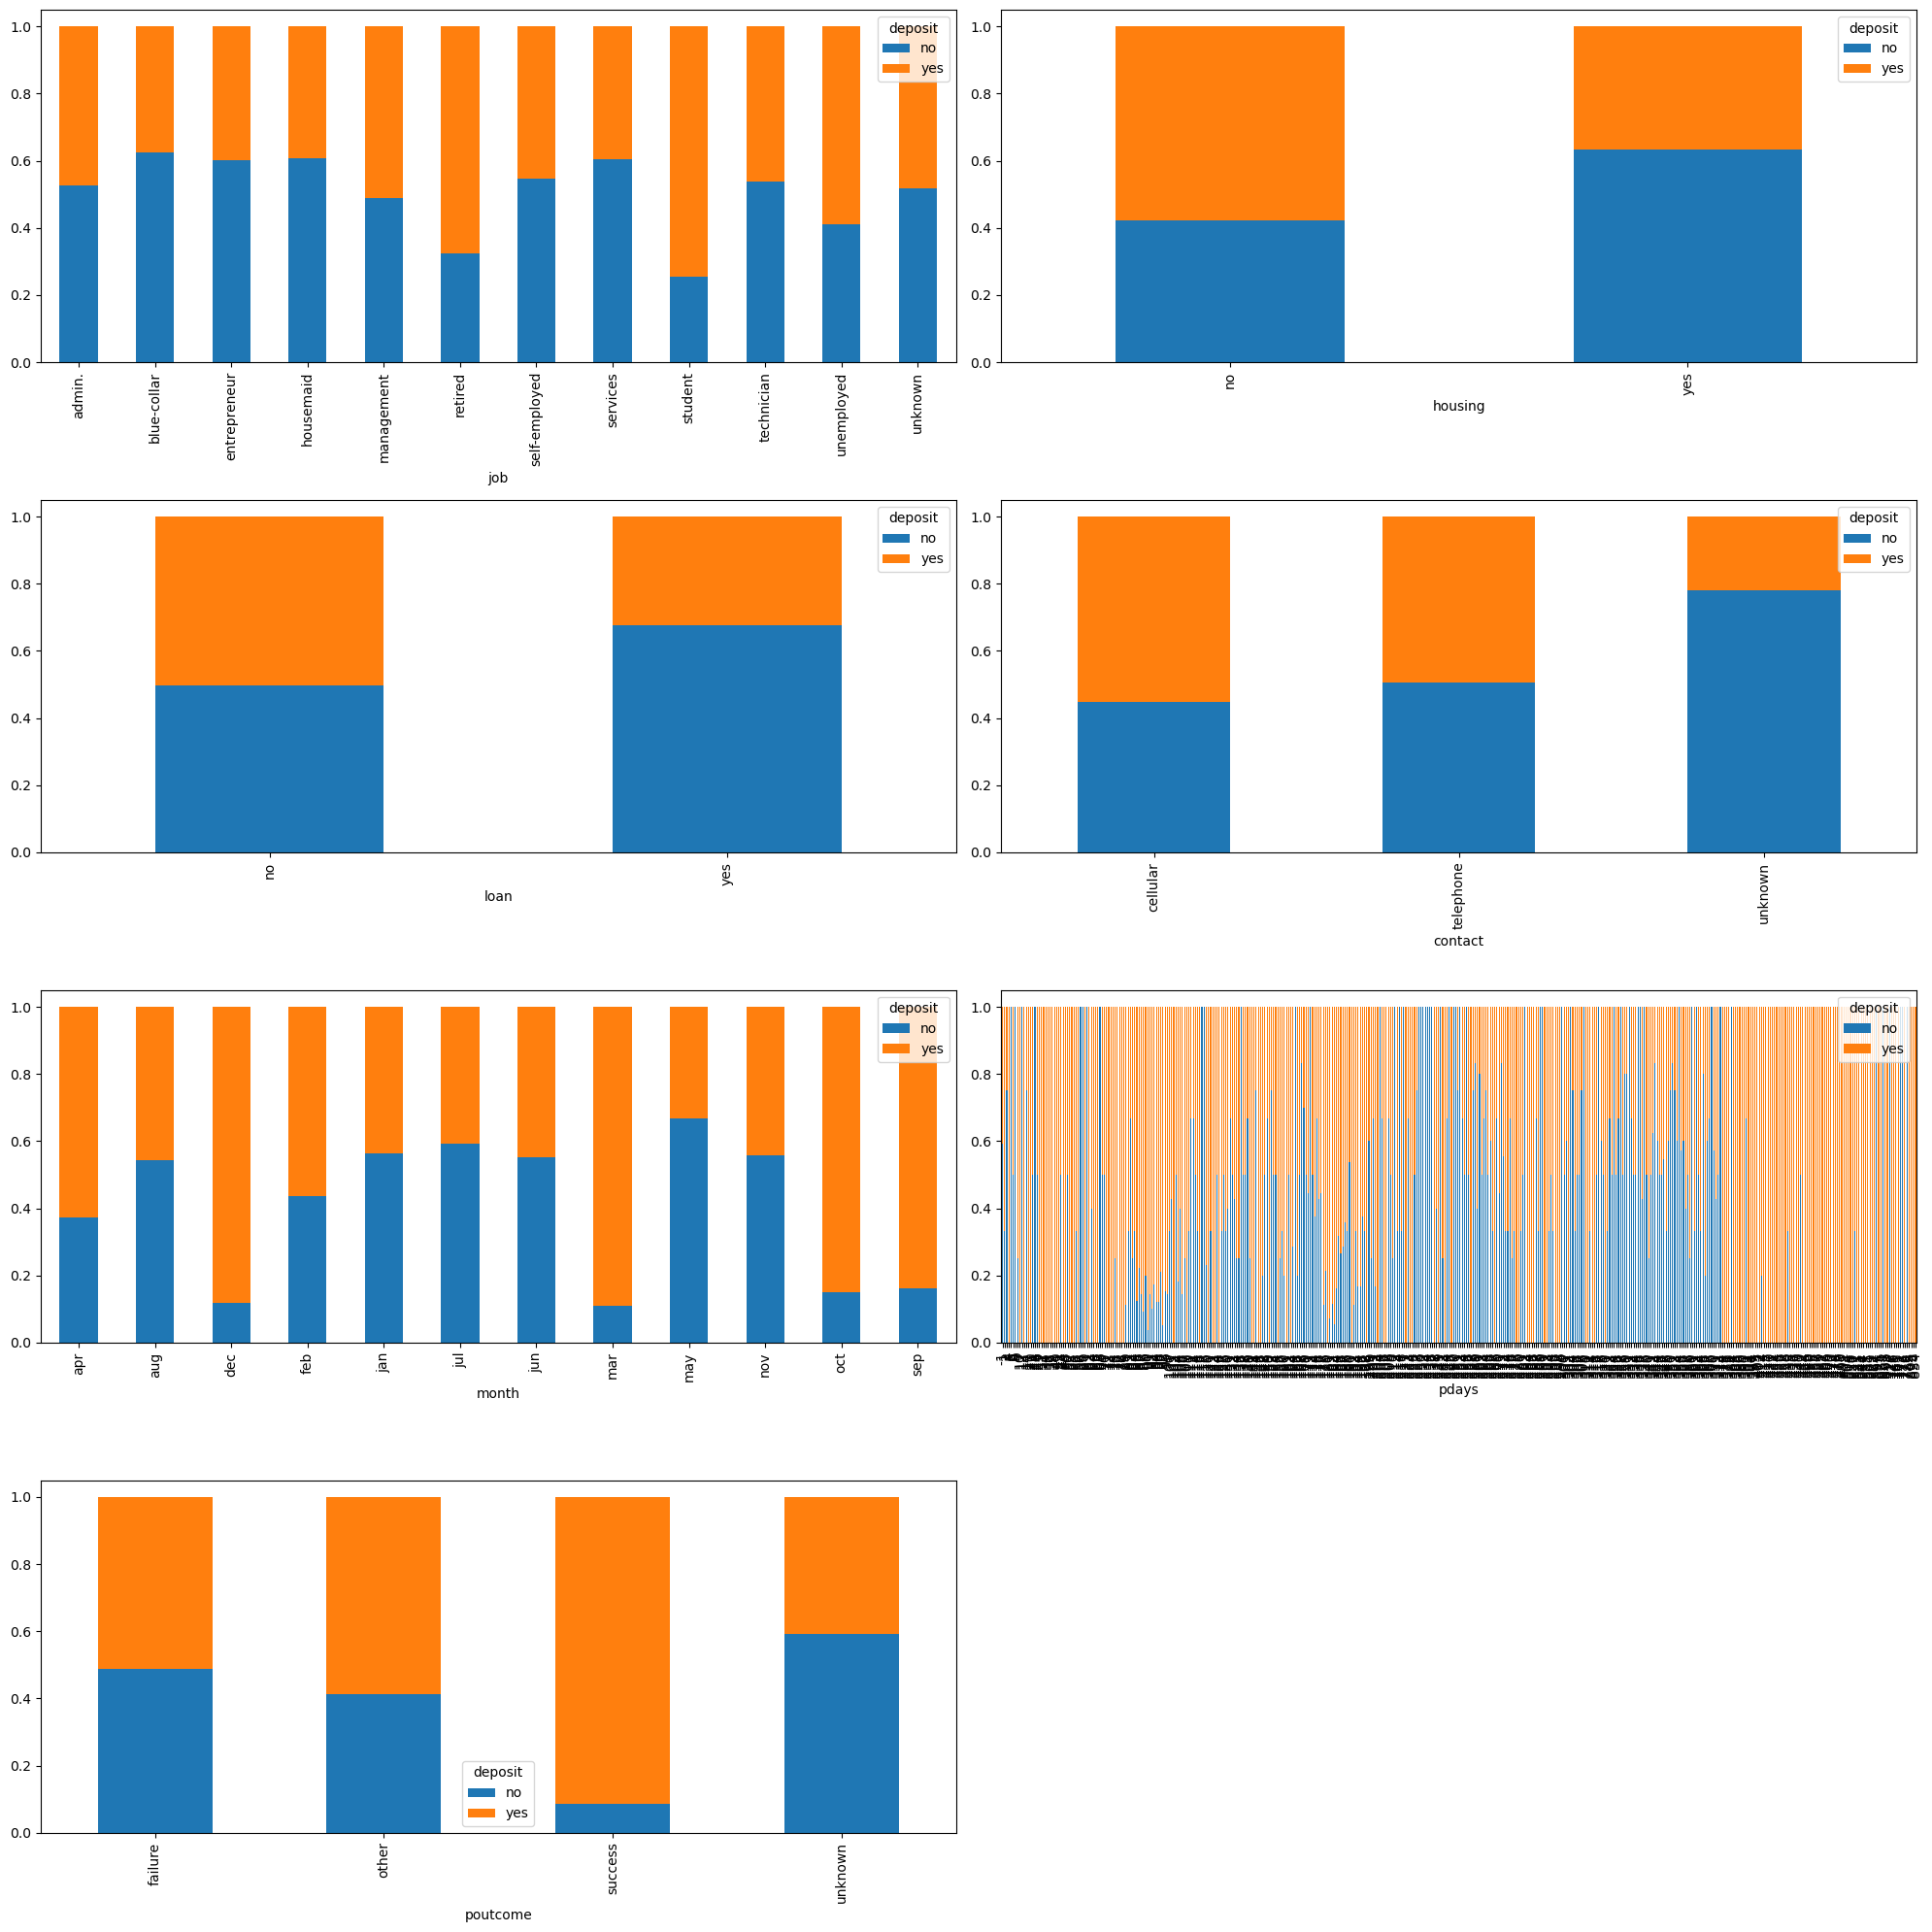

In [271]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['deposit','age','balance','campaign']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['deposit'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [272]:
X = df.drop(columns=['deposit'])
y = df['deposit']

In [273]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

## *Preprocessing*

In [274]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['job','housing', 'loan', 'contact', 'month', 'poutcome']),
    ('standar', StandardScaler(), ['age', 'campaign', 'balance', 'pdays']),
], remainder='passthrough')

Melakukan prapemrosesan data dalam analisis atau model machine learning:
1. OneHotEncoder: drop='first' digunakan untuk menghindari dummy variable trap dengan menghapus salah satu kategori.
2. Kolom 'job' ditransformasikan menggunakan OneHotEncoder, Karena merupakan kolom Categorical digunakan untuk mengonversi kolom kategorikal menjadi representasi numerik seperti angka desimal, pecahan, persen, atau daftar numerik
3. Kolom 'housing' ditransformasikan menggunakan OneHotEncoder, Karena merupakan kolom Categorical digunakan untuk mengonversi kolom kategorikal menjadi representasi numerik seperti angka desimal, pecahan, persen, atau daftar numerik
4. Kolom 'loan' ditransformasikan menggunakan OneHotEncoder, Karena merupakan kolom Categorical digunakan untuk mengonversi kolom kategorikal menjadi representasi numerik seperti angka desimal, pecahan, persen, atau daftar numerik
5. Kolom 'contact' ditransformasikan menggunakan OneHotEncoder, Karena merupakan kolom Categorical digunakan untuk mengonversi kolom kategorikal menjadi representasi numerik seperti angka desimal, pecahan, persen, atau daftar numerik
6. Kolom 'month' ditransformasikan menggunakan OneHotEncoder, Karena merupakan kolom Categorical digunakan untuk mengonversi kolom kategorikal menjadi representasi numerik seperti angka desimal, pecahan, persen, atau daftar numerik
7. Kolom 'poutcome' ditransformasikan menggunakan OneHotEncoder, Karena merupakan kolom Categorical digunakan untuk mengonversi kolom kategorikal menjadi representasi numerik seperti angka desimal, pecahan, persen, atau daftar numerik
8. Kolom 'age' ditransformasikan menggunakan StandardScaler, Karena merupakan kolom Numerical digunakan agar memiliki rata-rata 0 dan standar deviasi 1
9. Kolom 'campaign' ditransformasikan menggunakan StandardScaler, Karena merupakan kolom Numerical digunakan agar memiliki rata-rata 0 dan standar deviasi 1
10. Kolom 'balance' ditransformasikan menggunakan StandardScaler, Karena merupakan kolom Numerical digunakan agar memiliki rata-rata 0 dan standar deviasi 1
11. Kolom 'pdays' ditransformasikan menggunakan StandardScaler, Karena merupakan kolom Numerical digunakan agar memiliki rata-rata 0 dan standar deviasi 1

## *Cross validation*

In [275]:
# Konversi target menjadi numerik
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})


In [276]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Define models
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()


In [277]:
models = [logreg,knn,dt,rf,xgb]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess', transformer),
        ('model',i)
    ])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

In [278]:
results_df = pd.DataFrame({
    'model': models,
    'mean roc_auc': rata,
    'std roc_auc': std
})

# Tampilkan DataFrame
results_df

,model,mean roc_auc,std roc_auc
0,LogisticRegression(),0.759474,0.019347
1,KNeighborsClassifier(),0.717676,0.010717
2,DecisionTreeClassifier(),0.623848,0.012838
3,RandomForestClassifier(),0.759439,0.011602
4,"XGBClassifier(base_score=None, booster=None, c...",0.755019,0.009427


In [279]:
# best algo
tree = RandomForestClassifier()

Hasil diatas menunjukkan performa beberapa model klasifikasi yang dievaluasi menggunakan metrik ROC-AUC, Model RandomForestClassifier memiliki nilai mean ROC-AUC tertinggi (0.7598), menunjukkan kemampuan terbaik dalam membedakan kelas. Rekomendasi Model terbaik RandomForestClassifier Performa terbaik dan Stabilitas tinggi dengan standar deviasi rendah.

## *HyperParametertuning*

In [280]:
# hyperparameter tuning untuk model Logistic Regression
hyperparam = {
    'modeling__criterion':  ['gini', 'entropy', 'log_loss'],
    'modeling__splitter':  ['best', 'random'],
    'modeling__max_depth':  range(2,30),
    'modeling__min_samples_leaf':  range(2,30),
    'modeling__min_samples_split':  range(2,30),
    'preprocessing__robust' : [RobustScaler(), StandardScaler(), MinMaxScaler()]
}

Pipe_model = Pipeline([
    ('preprocessing',transformer),
    ('modeling', tree)
    ])

#define gridsearch
gridsearch = GridSearchCV(
    estimator = Pipe_model,
    cv = 5,
    scoring = 'recall',
    n_jobs= -1,
    param_grid= hyperparam   
)

randomsearch = RandomizedSearchCV(
    estimator = Pipe_model,
    param_distributions = hyperparam,
    n_jobs = -1,
    cv = 5,
    scoring = 'recall',
    n_iter = 200,
    random_state=0
)

randomsearch

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['job',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'poutcome']),
                                                                              ('standar',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'campaign',
                                                                                'balance',
                                                                                'pdays'])])),
                                             ('modeling',
                                              RandomForestClassifier())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'modeling__criterion': ['gini',
                                                                'entropy',
                                                                'log_loss'],
                                        'modeling__max_depth': range(2, 30),
                                        'modeling__min_samples_leaf': range(2, 30),
                                        'modeling__min_samples_split': range(2, 30),
                                        'modeling__splitter': ['best',
                                                               'random'],
                                        'preprocessing__robust': [RobustScaler(),
                                                                  StandardScaler(),
                                                                  MinMaxScaler()]},
                   random_state=0, scoring='recall')

In [281]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Preprocessing pipeline
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['job', 'housing', 'loan', 'contact', 'month', 'poutcome']),
    ('scale', StandardScaler(), ['age', 'campaign', 'balance', 'pdays'])
], remainder='passthrough')

# Define the model
rf = RandomForestClassifier(random_state=0)

# Define hyperparameter search space
param_distributions = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Full pipeline: preprocessing + model
pipeline = Pipeline([
    ('preprocessing', transformer),
    ('model', rf)
])

# Randomized search
randomsearch = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    random_state=0,
    verbose=1
)

# Fit the model
randomsearch.fit(X_train, y_train)

# Access results
df_cv_result = pd.DataFrame(randomsearch.cv_results_)
df_cv_result.sort_values(by='rank_test_score', ascending=True, inplace=True)

# Display sorted results
df_cv_result


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,3.551355,1.362244,0.053954,0.032271,100,10,2,None,"{'model__n_estimators': 100, 'model__min_sampl...",0.714972,0.751801,0.698959,0.737390,0.732372,0.727099,0.018346,1
6,6.795941,0.248195,0.128343,0.028747,200,10,4,30,"{'model__n_estimators': 200, 'model__min_sampl...",0.715773,0.745396,0.701361,0.739792,0.717147,0.723894,0.016336,2
5,3.301770,0.037919,0.066997,0.016044,100,2,4,30,"{'model__n_estimators': 100, 'model__min_sampl...",0.714972,0.740592,0.705364,0.733387,0.721154,0.723094,0.012619,3
2,1.700648,0.161252,0.047695,0.008642,50,5,4,20,"{'model__n_estimators': 50, 'model__min_sample...",0.714972,0.744596,0.701361,0.734187,0.716346,0.722292,0.015271,4
4,1.631165,0.042029,0.041955,0.004509,50,10,4,None,"{'model__n_estimators': 50, 'model__min_sample...",0.708567,0.742194,0.702962,0.731785,0.721955,0.721493,0.014458,5
1,3.679612,0.174703,0.055070,0.009888,100,2,2,None,"{'model__n_estimators': 100, 'model__min_sampl...",0.714171,0.729384,0.695757,0.734187,0.720353,0.718770,0.013443,6
7,4.868770,0.971234,0.085211,0.029908,100,10,1,None,"{'model__n_estimators': 100, 'model__min_sampl...",0.712570,0.728583,0.696557,0.734988,0.717147,0.717969,0.013346,7
9,6.330533,0.066571,0.088966,0.014561,200,5,1,30,"{'model__n_estimators': 200, 'model__min_sampl...",0.713371,0.728583,0.688551,0.730985,0.715545,0.715407,0.015111,8
0,2.658455,0.321157,0.053953,0.019429,50,5,1,30,"{'model__n_estimators': 50, 'model__min_sample...",0.715773,0.721377,0.687750,0.729384,0.714744,0.713805,0.014026,9
3,12.170518,1.101119,0.137310,0.012032,200,2,1,None,"{'model__n_estimators': 200, 'model__min_sampl...",0.709367,0.718975,0.685348,0.721377,0.707532,0.708520,0.012753,10


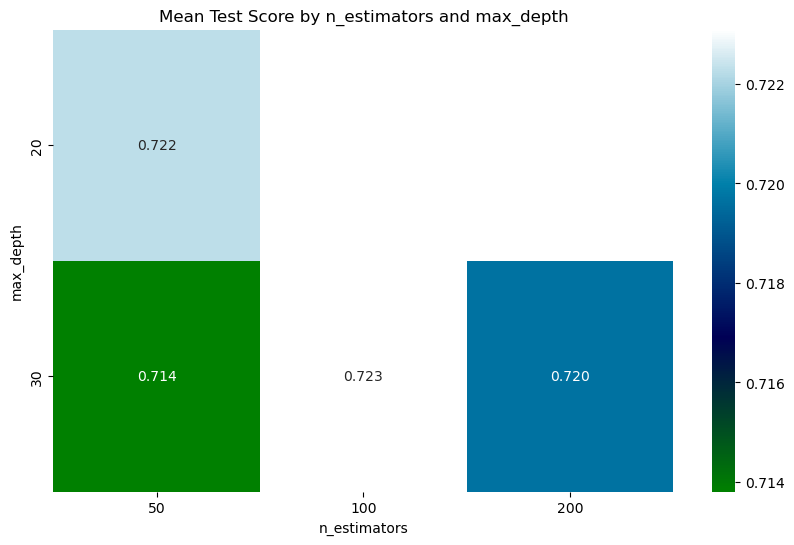

C:\Users\T470\AppData\Local\Temp\ipykernel_15872\1430547143.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\T470\AppData\Local\Temp\ipykernel_15872\1430547143.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


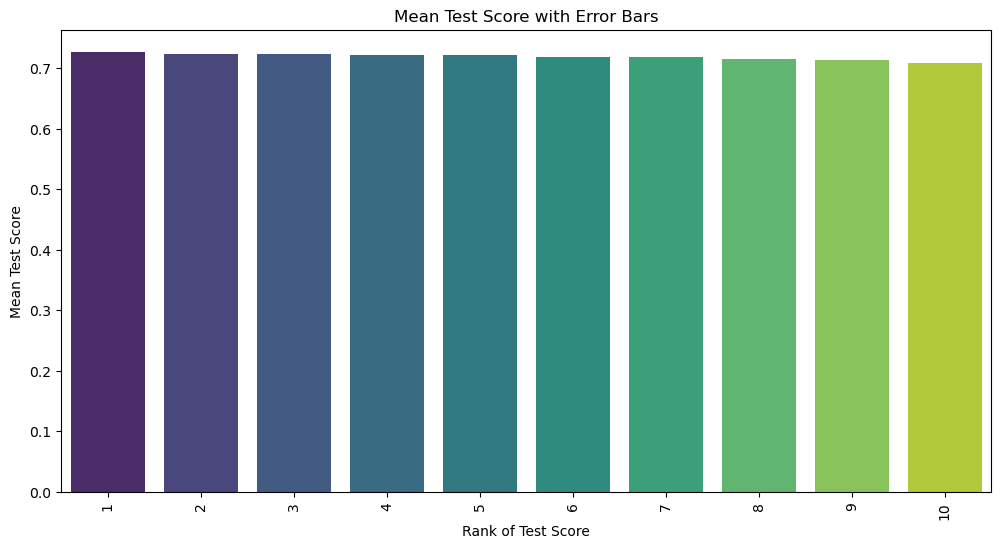

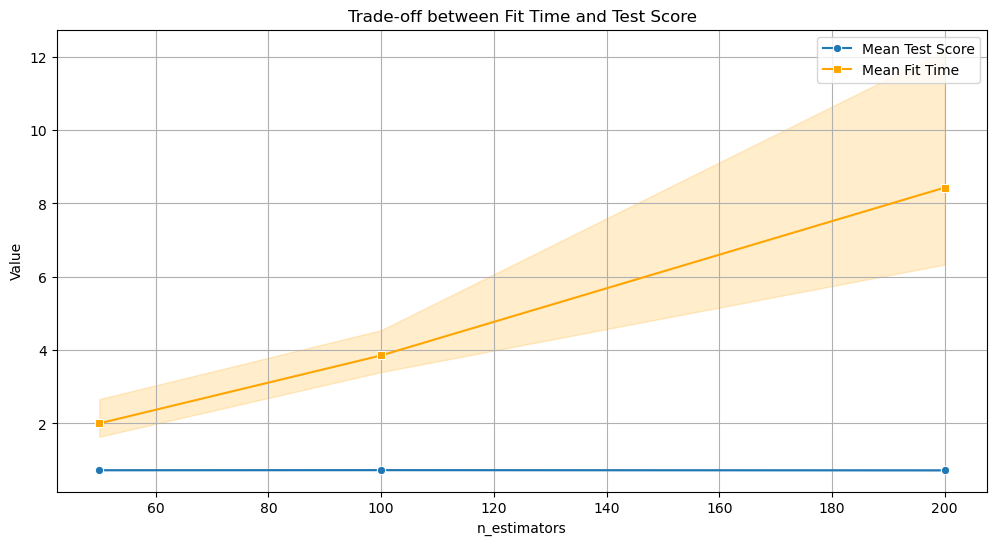

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort results by mean_test_score for better visualization
df_cv_result = df_cv_result.sort_values(by='mean_test_score', ascending=False)

# Extracting relevant columns for visualization
df_cv_result['n_estimators'] = df_cv_result['param_model__n_estimators'].astype(int)
df_cv_result['max_depth'] = df_cv_result['param_model__max_depth'].astype(str)
df_cv_result['min_samples_split'] = df_cv_result['param_model__min_samples_split'].astype(int)
df_cv_result['min_samples_leaf'] = df_cv_result['param_model__min_samples_leaf'].astype(int)

# 1. Heatmap: Mean Test Score by n_estimators and max_depth
heatmap_data = df_cv_result.pivot_table(
    index='param_model__max_depth',
    columns='param_model__n_estimators',
    values='mean_test_score'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="ocean")
plt.title("Mean Test Score by n_estimators and max_depth")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

# 2. Bar Chart: Mean Test Score with Std Error
# Bar Chart: Mean Test Score with Std Error
plt.figure(figsize=(12, 6))
sns.barplot(
    x=df_cv_result['rank_test_score'], 
    y=df_cv_result['mean_test_score'], 
    capsize=0.2,  # Remove yerr, seaborn automatically calculates error bars
    ci='sd',       # Use standard deviation for error bars
    palette='viridis'
)
plt.title("Mean Test Score with Error Bars")
plt.xlabel("Rank of Test Score")
plt.ylabel("Mean Test Score")
plt.xticks(rotation=90)
plt.show()

# 3. Line Plot: Mean Fit Time vs Mean Test Score
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=df_cv_result['param_model__n_estimators'], 
    y=df_cv_result['mean_test_score'], 
    marker='o', 
    label='Mean Test Score'
)
sns.lineplot(
    x=df_cv_result['param_model__n_estimators'], 
    y=df_cv_result['mean_fit_time'], 
    marker='s', 
    label='Mean Fit Time', 
    color='orange'
)
plt.title("Trade-off between Fit Time and Test Score")
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


Hasil ini menunjukkan evaluasi berbagai kombinasi hyperparameter untuk model Random Forest Classifier menggunakan validasi silang. 
1. Parameter:
 n_estimators: 100
 min_samples_split: 10
 min_samples_leaf: 2
 max_depth: None

2. Skor:
mean_test_score: 0.727099 (tertinggi).
std_test_score: 0.018346 (relatif stabil).

In [282]:
best_model = randomsearch.best_params_

In [283]:
randomsearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'housing', 'loan',
                                                   'contact', 'month',
                                                   'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'campaign', 'balance',
                                                   'pdays'])])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=2,
                                        min_samples_split=10,
                                        random_state=0))])

In [284]:
from sklearn.metrics import recall_score

# Fit model menggunakan data training
estimator.fit(X_train, y_train)

# Prediksi terhadap data uji
y_pred_before = estimator.predict(X_test)

# Calculate recall score
recall = recall_score(y_test, y_pred_before)

# Print the recall
print("Recall score:", recall)


Recall score: 0.6273458445040214


In [285]:
from sklearn.metrics import recall_score

# Pastikan target y_test sudah dikonversi ke numerik, jika perlu
if y_test.dtype == 'object':  # Jika masih dalam bentuk 'yes' dan 'no'
    y_test = y_test.map({'yes': 1, 'no': 0})

# Gunakan model yang sudah dilatih untuk membuat prediksi pada data uji
# Contoh dengan model estimator yang sudah didefinisikan
estimator = Pipeline([
    ('preprocess', transformer),  # Preprocessor yang sudah Anda definisikan
    ('model', rf)                 # Model yang dilatih (contoh: Random Forest)
])

# Fit model menggunakan data training
estimator.fit(X_train, y_train)

# Prediksi terhadap data uji
y_pred_after = estimator.predict(X_test)

# Hitung recall score dengan label positif numerik (sesuai konversi)
recall = recall_score(y_test, y_pred_after, pos_label=1)

# Cetak hasil recall
print("Recall score:", recall)


Recall score: 0.6474530831099196


C:\Users\T470\AppData\Local\Temp\ipykernel_15872\3660570427.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=recall_scores, palette='coolwarm')


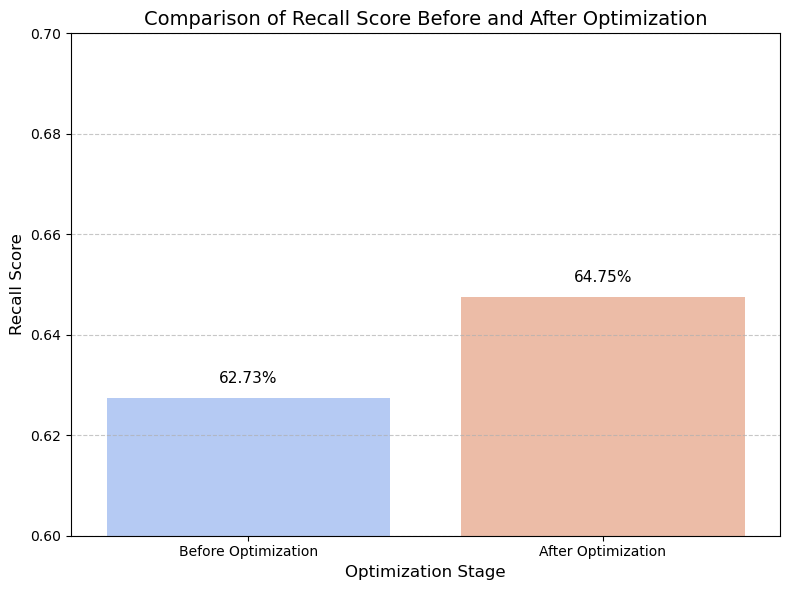

In [298]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score

# Contoh data (Recall sebelum dan sesudah, masukkan nilai sesuai hasil Anda)
recall_scores = [0.6273458445040214, 0.6474530831099196]
labels = ['Before Optimization', 'After Optimization']

# Visualisasi dengan Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=recall_scores, palette='coolwarm')

# Tambahkan detail visual
plt.title('Comparison of Recall Score Before and After Optimization', fontsize=14)
plt.ylabel('Recall Score', fontsize=12)
plt.xlabel('Optimization Stage', fontsize=12)
plt.ylim(0.6, 0.7)  # Fokus pada kisaran recall
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotasi nilai di atas bar
for i, score in enumerate(recall_scores):
    plt.text(i, score + 0.003, f"{score:.2%}", ha='center', fontsize=11)

# Tampilkan grafik
plt.tight_layout()
plt.show()


In [286]:
from sklearn.metrics import precision_score

# Menghitung precision
precision = precision_score(y_test, y_pred_before)  # Pastikan label positif sesuai
print(f"Precision: {precision:.4f}")

Precision: 0.7222


In [287]:
from sklearn.metrics import precision_score

# Menghitung precision
precision = precision_score(y_test, y_pred_after)  # Pastikan label positif sesuai
print(f"Precision: {precision:.4f}")

Precision: 0.7124


C:\Users\T470\AppData\Local\Temp\ipykernel_15872\3889043236.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=precision_scores, palette='muted')


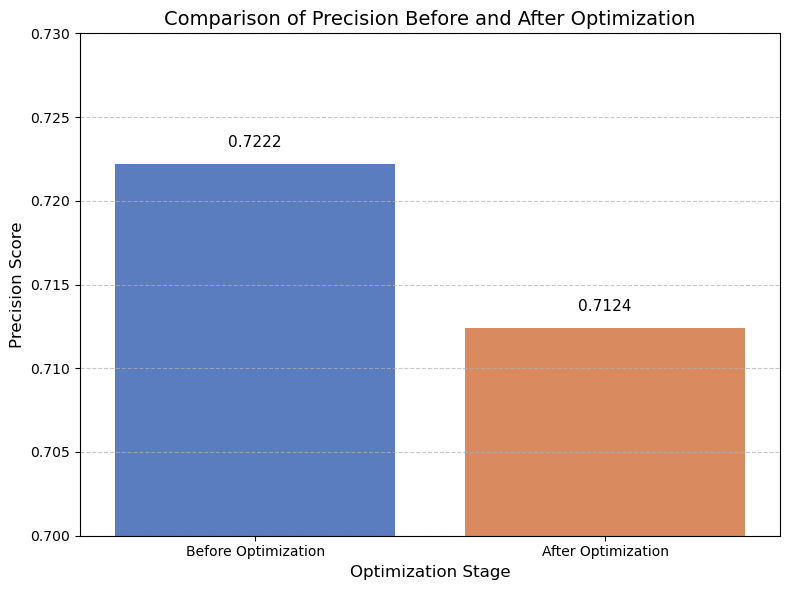

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh data (Precision sebelum dan sesudah)
precision_scores = [0.7222, 0.7124]
labels = ['Before Optimization', 'After Optimization']

# Visualisasi Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=precision_scores, palette='muted')

# Tambahkan detail visual
plt.title('Comparison of Precision Before and After Optimization', fontsize=14)
plt.ylabel('Precision Score', fontsize=12)
plt.xlabel('Optimization Stage', fontsize=12)
plt.ylim(0.7, 0.73)  # Fokus pada kisaran precision
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotasi nilai di atas bar
for i, score in enumerate(precision_scores):
    plt.text(i, score + 0.001, f"{score:.4f}", ha='center', fontsize=11)

# Tampilkan grafik
plt.tight_layout()
plt.show()


hyperparameter terbaik berdasarkan hasil tuning:
1. Akurasi: Kombinasi ini menghasilkan mean test score sebesar 0.7271, tertinggi di antara semua kombinasi yang diuji.
    - Dengan akurasi ini, model dapat mengklasifikasikan pelanggan yang akan melakukan deposito dan tidak akan melakukan deposito dengan tingkat keberhasilan 72.71
    - Model ini membantu mengidentifikasi kelompok pelanggan yang lebih mungkin membuka deposito, sehingga kampanye pemasaran dapat diarahkan dengan lebih tepat sasaran.
    - Misalnya, sumber daya pemasaran (telepon, email, kunjungan langsung) dapat difokuskan pada 27% pelanggan yang diprediksi memiliki potensi tinggi.
2. Stabilitas: Standar deviasi skor adalah 0.0183, menunjukkan performa model yang stabil di berbagai fold validasi silang.
    - Standar deviasi yang rendah menunjukkan bahwa model memiliki performa konsisten di berbagai fold validasi silang, memberikan keyakinan bahwa model akan bekerja dengan baik pada data baru (data pelanggan sebenarnya). Ini menandakan bahwa prediksi model tidak terlalu terpengaruh oleh fluktuasi dalam distribusi data.
    - Dengan model yang stabil, manajemen dapat mengandalkan prediksi untuk membuat keputusan strategis, seperti menentukan segmentasi pelanggan atau merancang strategi pemasaran baru.


Nilai Recall: 0.6273458445040214 62.73%  Dari 100 kasus positif sebenarnya, sekitar 63 berhasil diidentifikasi, Model menunjukkan performa yang cukup baik dalam mendeteksi kasus positif.

Hasil Recall Setelah Pembaruan:

1. Recall Score = 0.6474530831099196 (64.74%) Model berhasil mendeteksi sekitar 64.74% True Positives, Sebanyak 35.26% False negatives.Hasil evaluasi model menunjukkan bahwa recall score sebesar 64.74% berarti model mampu mendeteksi 64.74% pelanggan yang benar-benar akan membuka deposito (True Positives). Namun, sebanyak 35.26% pelanggan yang sebenarnya prospektif tidak terdeteksi oleh model (False Negatives).
- True Positives (64.74%):
    - Pelanggan yang diprediksi akan membuka deposito oleh model, dan benar-benar melakukannya.
    - Representasi pelanggan ini adalah kelompok yang perlu dijadikan target utama dalam kampanye pemasaran, karena model dapat secara efektif mengidentifikasi mereka.
- False Negatives (35.26%):
    - Pelanggan yang sebenarnya akan membuka deposito, tetapi model gagal mendeteksi mereka.
    - Peluang bisnis hilang karena kelompok ini tidak ditargetkan dalam kampanye pemasaran.


## *Conclusion metric*

In [288]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [289]:
# confusion matrix before
cm_before = confusion_matrix(y_test, y_pred_before)

# confusion matrix after
cm_after = confusion_matrix(y_test, y_pred_after)

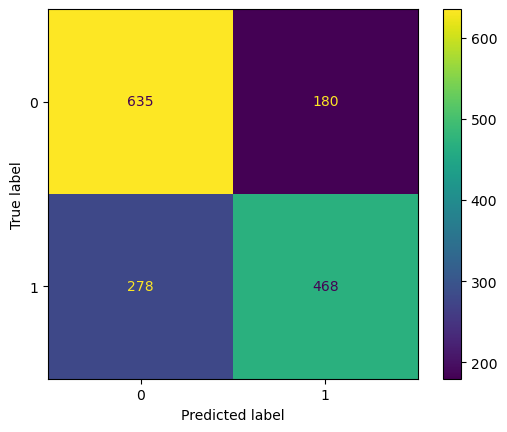

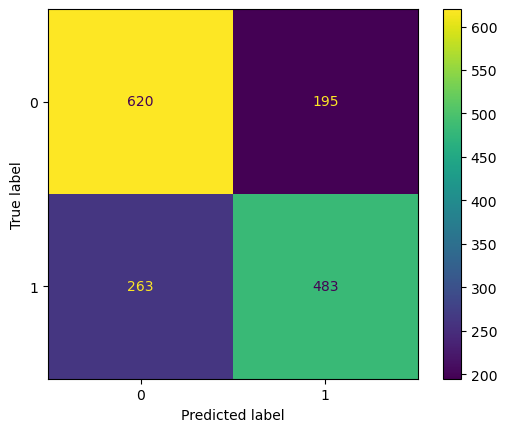

In [290]:
disp_before = ConfusionMatrixDisplay(cm_before)

disp_after = ConfusionMatrixDisplay(cm_after)

disp_before.plot()

disp_after.plot()


- Before:
    - True Negatives (TN): 635
    - False Positives (FP): 180
    - False Negatives (FN): 278
    - True Positives (TP): 468
- After:
    - True Negatives (TN): 620
    - False Positives (FP): 195
    - False Negatives (FN): 263
    - True Positives (TP): 483

In [291]:
randomsearch.best_estimator_[-1].feature_importances_

array([0.01582886, 0.00632692, 0.00548865, 0.01377495, 0.01032998,
       0.00582326, 0.0089305 , 0.00640672, 0.0122424 , 0.00632299,
       0.00175446, 0.05234979, 0.02458199, 0.0126208 , 0.08347602,
       0.0195577 , 0.0030348 , 0.0090114 , 0.01079667, 0.01831542,
       0.0212855 , 0.01923223, 0.02073081, 0.01561161, 0.01911317,
       0.01025132, 0.00578014, 0.07670844, 0.02876995, 0.1392503 ,
       0.07282879, 0.16120472, 0.08225874])

- True Positives (TP): 483 nasabah diprediksi benar akan berlangganan.
Dampak Bisnis: Kampanye pemasaran terhadap nasabah ini lebih efektif karena benar-benar berpotensi membeli produk.
- False Positives (FP): 195 nasabah diprediksi salah akan berlangganan.
- Dampak Bisnis: Upaya pemasaran ke nasabah ini tidak akan menghasilkan keuntungan, menyebabkan pemborosan sumber daya.
- True Negatives (TN): 620 nasabah diprediksi benar tidak akan berlangganan.
Dampak Bisnis: Menghindari biaya pemasaran pada nasabah yang tidak tertarik, sehingga mengurangi pemborosan.
- False Negatives (FN): 263 nasabah sebenarnya tertarik, tetapi diprediksi tidak.
Dampak Bisnis: Peluang pendapatan dari nasabah ini hilang karena mereka tidak ditargetkan dalam kampanye pemasaran.

Recall (64.74%):
- Dampak Positif: Model mampu menangkap mayoritas (61.8%) nasabah yang benar-benar tertarik, memastikan sebagian besar peluang pendapatan tetap dimanfaatkan.
- Dampak Negatif: Dengan 35.26% FN (nasabah yang terlewat), ada potensi kehilangan pendapatan dari segmen ini. Jika biaya kehilangan peluang lebih besar daripada biaya pemasaran, ini perlu diperbaiki.

Precision (71.2%):
- Dampak Positif: Dengan precision tinggi, 71.2% dari nasabah yang ditargetkan memang benar-benar tertarik. Ini mengurangi biaya pemasaran yang sia-sia pada nasabah yang tidak tertarik.
- Dampak Negatif: Walaupun FP lebih sedikit (195), mereka masih menyebabkan pemborosan, terutama jika biaya per nasabah yang tidak tertarik tinggi.

## *Conclusion*

- Bisnis harus mempertimbangkan segmentasi nasabah berbasis beberapa fitur unik, seperti saldo, riwayat kontak, dan preferensi, daripada hanya usia atau jumlah kampanye.
- Optimasi Kampanye: Gunakan pendekatan berbasis data untuk mengoptimalkan kampanye pemasaran. Misalnya, nasabah yang terlalu sering dihubungi (tinggi campaign) dengan waktu kontak terakhir yang pendek (pdays) harus diprioritaskan untuk strategi retensi nasabah.
- Fokus pada nasabah dengan saldo tinggi untuk peluang upselling atau layanan premium, karena mereka cenderung lebih responsif terhadap kontak bisnis.
- Fokuskan kampanye pemasaran deposito ke nasabah dengan saldo lebih tinggi, seperti dengan mengirimkan penawaran yang dipersonalisasi.
- Edukasi nasabah dengan saldo rendah untuk meningkatkan tabungan mereka sebelum menawarkan deposito.
- Usia bukan satu-satunya faktor pembeda utama untuk keputusan deposit. Namun, kelompok usia produktif (sekitar 30-50 tahun) tetap menjadi fokus utama.
- Kampanye yang ditargetkan berdasarkan hasil model mengurangi biaya yang dihabiskan untuk nasabah yang tidak memiliki kemungkinan tinggi untuk membuka deposito.
- Karena model stabil, pendekatan ini dapat diterapkan pada basis nasabah yang lebih luas tanpa khawatir performa model akan menurun secara signifikan.
- Efisiensi Pemasaran:Model sudah cukup baik dalam mendeteksi nasabah prospektif, sehingga dapat membantu tim pemasaran untuk fokus pada nasabah yang lebih mungkin membuka deposito.
- Meningkatkan Konversi:Dengan menargetkan nasabah yang teridentifikasi sebagai prospektif, bisnis dapat meningkatkan peluang konversi deposito.
- True Positives (TP): Peningkatan (+15): Model yang diperbarui berhasil mendeteksi 15 nasabah tambahan yang benar-benar akan membuka deposito. Ini berkontribusi langsung pada peningkatan pendapatan karena bisnis dapat menargetkan lebih banyak nasabah prospektif untuk membuka deposito.
- Efisiensi pemasaran meningkat karena lebih banyak nasabah yang benar-benar prospektif terdeteksi.
- False Negatives (FN): Penurunan (-15): Berkurangnya jumlah nasabah yang tidak terdeteksi meskipun mereka prospektif berarti lebih sedikit peluang bisnis yang terlewat. Penurunan False Negatives ini mencerminkan kemampuan model yang lebih baik dalam mengidentifikasi nasabah yang tepat.
- Kesempatan untuk menjangkau lebih banyak nasabah prospektif meningkat, mengurangi potensi kerugian akibat nasabah yang tidak diprediksi.
- False Positives (FP): Peningkatan (+15): Peningkatan False Positives berarti lebih banyak nasabah yang diprediksi akan membuka deposito tetapi sebenarnya tidak akan melakukannya. Hal ini dapat menyebabkan pengeluaran pemasaran yang tidak efisien, karena anggaran digunakan untuk menargetkan nasabah yang kurang relevan.
- Meningkatkan biaya pemasaran tanpa hasil yang signifikan. Dapat menurunkan pengalaman nasabah, terutama jika mereka merasa terlalu sering dihubungi untuk produk yang tidak relevan.
- True Negatives (TN): Penurunan (-15): Penurunan deteksi nasabah yang memang tidak akan membuka deposito berarti model menjadi sedikit lebih longgar dalam menyingkirkan nasabah yang tidak relevan. 
- Berisiko menambah beban pada tim pemasaran karena meningkatnya jumlah nasabah yang sebenarnya tidak prospektif.
- Kinerja Positif:
    - Model yang diperbarui menunjukkan peningkatan kemampuan untuk mendeteksi nasabah prospektif (TP), sehingga menghasilkan peluang bisnis yang lebih besar.
    - Penurunan False Negatives menunjukkan lebih banyak nasabah yang benar-benar potensial dapat diidentifikasi.
- Area untuk Diperbaiki:
    - Peningkatan False Positives dan penurunan True Negatives menunjukkan adanya biaya tambahan pada pemasaran dan potensi gangguan pada nasabah yang tidak relevan.

## *Recommendation*

- Usia (age) tidak berhubungan signifikan dengan saldo nasabah (balance) atau jumlah kampanye yang diikuti (campaign). Oleh karena itu, segmentasi nasabah berdasarkan usia mungkin kurang relevan jika tujuan Anda adalah menargetkan nasabah berdasarkan kampanye pemasaran.
- Hubungan Antara campaign dan pdays:
    - Disarankan untuk mengatur frekuensi kontak secara bijaksana agar tidak membuat nasabah merasa terganggu (menghindari "over-marketing").
- Korelasi antara balance dan pdays:
    - Pelanggan dengan saldo lebih tinggi mungkin cenderung tetap dalam kontak lebih lama dengan bisnis.Bisnis dapat memanfaatkan ini untuk menargetkan nasabah dengan saldo tinggi melalui penawaran atau promosi eksklusif.
- Korelasi sangat rendah antara usia dan variabel lain seperti saldo (balance) atau jumlah kampanye (campaign):
    - Alih-alih berfokus pada usia, perusahaan dapat mempertimbangkan faktor lain seperti riwayat kontak atau status keuangan.
- Karena tidak ada hubungan korelasi yang kuat, ini menunjukkan bahwa tidak ada satu variabel tunggal yang dominan memengaruhi hasil (seperti kesuksesan kampanye pemasaran). Strategi pemasaran harus mempertimbangkan beberapa faktor secara bersamaan. Bisnis harus mempertimbangkan segmentasi nasabah berbasis beberapa fitur unik, seperti saldo, riwayat kontak, dan preferensi, daripada hanya usia atau jumlah kampanye.
- Gunakan pendekatan berbasis data untuk mengoptimalkan kampanye pemasaran. Misalnya, nasabah yang terlalu sering dihubungi (tinggi campaign) dengan waktu kontak terakhir yang pendek (pdays) harus diprioritaskan untuk strategi retensi nasabah.
- Fokus pada nasabah dengan saldo tinggi untuk peluang upselling atau layanan premium, karena mereka cenderung lebih responsif terhadap kontak bisnis.
- Histogram Age:
    - Kelompok usia 30-50 tahun adalah target yang lebih prospektif untuk kampanye deposito, karena mereka menunjukkan kecenderungan lebih tinggi untuk membuka deposito.Strategi pemasaran dapat disesuaikan untuk kelompok usia ini dengan penawaran yang relevan, seperti promosi investasi jangka panjang atau bunga deposito yang kompetitif.
- Histogram Balance:
    - Pelanggan dengan saldo yang lebih besar dapat dianggap memiliki kapasitas finansial lebih baik untuk berinvestasi. Fokuskan kampanye pemasaran deposito ke nasabah dengan saldo lebih tinggi, seperti dengan mengirimkan penawaran yang dipersonalisasi.Edukasi nasabah dengan saldo rendah untuk meningkatkan tabungan mereka sebelum menawarkan deposito.
- Boxplot Age:
    - Usia bukan satu-satunya faktor pembeda utama untuk keputusan deposit. Namun, kelompok usia produktif (sekitar 30-50 tahun) tetap menjadi fokus utama.
- Boxplot Campaign:
    - Over-Marketing Warning: Menghubungi nasabah terlalu sering dapat menurunkan efektivitas kampanye dan bahkan mengganggu nasabah.Tentukan batas maksimum frekuensi kontak untuk setiap nasabah berdasarkan respons historis.Prioritaskan pendekatan yang lebih personal dan strategis daripada frekuensi kontak tinggi.
- Fokus pada Segmen Prospektif:Kelompok usia 30-50 tahun dan nasabah dengan saldo tinggi memiliki potensi lebih besar untuk membuka deposito.
- Optimalkan Frekuensi Kontak:Hindari menghubungi nasabah terlalu sering. Fokuskan pada nasabah yang menunjukkan potensi tinggi berdasarkan saldo atau preferensi historis.
- Penawaran Khusus:Sediakan promosi yang menarik untuk nasabah dengan saldo besar atau nasabah baru yang masuk ke segmen usia produktif.
- Untuk nasabah dengan saldo rendah, edukasi mereka tentang pentingnya tabungan atau manfaat deposito untuk mendorong minat mereka.
- akurasi 72.71% dengan standar deviasi 1.83%:
    - Penghematan Biaya:Dengan mengurangi upaya pemasaran pada nasabah yang tidak prospektif, bisnis dapat mengalokasikan anggaran pemasaran ke area yang lebih produktif.
    - Kepercayaan pada Data:Stabilitas model mendukung keputusan berbasis data, memberikan keyakinan pada manajemen untuk mengandalkan prediksi ini dalam skala besar.
    - Meningkatkan Loyalitas Pelanggan:Penawaran yang lebih relevan kepada nasabah yang benar-benar potensial dapat meningkatkan kepuasan dan loyalitas mereka, yang berdampak pada hubungan jangka panjang.
- Optimalisasi lebih lanjut pada model, analisis kelompok False Negatives, dan strategi pemasaran tambahan untuk menjangkau nasabah yang tidak terdeteksi adalah langkah penting untuk meningkatkan performa bisnis.
- Penambahan Fitur Baru:Tambahkan fitur berdasarkan data historis atau perilaku nasabah, seperti interaksi terakhir dengan bank atau riwayat transaksi.
- Gunakan feature engineering untuk menemukan pola tersembunyi yang dapat membantu membedakan nasabah prospektif.
- Nasabah FN mungkin tidak memberikan banyak sinyal kuat dalam data historis, tetapi dengan pendekatan yang tepat, mereka bisa dikonversi menjadi nasabah deposito. Lakukan segmentasi pada kelompok FN untuk melihat pola.Jika FN banyak terdapat di kelompok tertentu (misalnya, usia muda dengan saldo kecil), buat kampanye yang relevan untuk kelompok ini.
- Hubungi beberapa nasabah dari kategori FN untuk memahami alasan mengapa mereka tertarik dengan deposito tetapi tidak terdeteksi oleh model. Masukan dari nasabah dapat digunakan untuk memperbaiki proses analitik data atau layanan.
- Edukasi nasabah tentang manfaat deposito, khususnya untuk kelompok FN yang mungkin belum memiliki informasi cukup.Gunakan pendekatan digital seperti email, SMS, atau media sosial untuk menjangkau nasabah FN.
- Tawarkan insentif seperti tingkat bunga lebih tinggi atau bonus untuk pembukaan deposito pertama. Promosi ini bisa diberikan kepada nasabah yang sebelumnya tidak terdeteksi (FN) tetapi memiliki potensi besar.
- Peningkatan Fitur Digital Banking: Tambahkan pengingat atau notifikasi personal di aplikasi banking untuk nasabah FN tentang peluang pembukaan deposito. Gunakan data untuk memberikan rekomendasi berbasis perilaku, misalnya, "Berdasarkan saldo Anda, deposito RpX dapat memberikan keuntungan Y.
- Peningkatan Revenue: Dengan mengurangi False Negatives, bisnis akan mendapatkan lebih banyak nasabah prospektif yang membuka deposito, sehingga meningkatkan pendapatan langsung.
- Dengan strategi pemasaran tambahan, bisnis dapat menjangkau nasabah yang sebelumnya tidak terdeteksi, memberikan pengalaman yang lebih baik, dan meningkatkan peluang konversi.Analisis kelompok FN memberikan wawasan yang lebih dalam tentang pola perilaku nasabah yang dapat digunakan untuk memperbaiki model dan strategi pemasaran.
- Fokus pada Pengurangan False Positives: Tambahkan lebih banyak fitur atau gunakan model tambahan untuk meningkatkan akurasi prediksi nasabah yang benar-benar relevan.Optimalkan threshold prediksi untuk menyeimbangkan trade-off antara recall dan precision.
- Optimalkan Targeting nasabah Prospektif:Untuk nasabah yang terdeteksi sebagai prospektif (TP), gunakan strategi pemasaran personalisasi untuk meningkatkan peluang konversi.
- Pengelolaan nasabah Non-Prospektif: Pastikan komunikasi dengan nasabah yang masuk kategori FP tidak terlalu agresif agar tidak menurunkan kepuasan nasabah secara keseluruhan.


# *Good luck & Thank you*